# Deploying Janus-Pro model on Amazon SageMaker with PyTorch DLC

❗This notebook works well on `ml.t3.medium` instance with `PyTorch 2.2.0 Python 3.10 CPU optimized` kernel from **SageMaker Studio Classic** or `Python3` kernel from **JupyterLab**.

## Set up Environment

In [ ]:
%%capture --no-stderr

!pip install huggingface-hub==0.28.1

In [ ]:
import boto3
import sagemaker


region = boto3.Session().region_name
role = sagemaker.get_execution_role()

sess = sagemaker.Session()
bucket = sess.default_bucket()
bucket

## Upload the `model.tar.gz`

Create and upload `model.tar.gz` to our sagemaker session bucket.

In [ ]:
HF_MODEL_ID = "deepseek-ai/Janus-Pro-7B"

base_name = HF_MODEL_ID.split('/')[-1].replace('.', '-').lower()
base_name

In [ ]:
%%time

# Create SageMaker model.tar.gz artifact
!mkdir -p model
!rm -f dummy-model.tar.gz
!tar --exclude "*/.ipynb_checkpoints*" -czvf dummy-model.tar.gz -C model .
!tar -tvf dummy-model.tar.gz
!ls -lh dummy-model.tar.gz

In [ ]:
from sagemaker.s3 import S3Uploader

# upload model.tar.gz to s3
s3_model_uri = S3Uploader.upload(
    local_path="./dummy-model.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{base_name}"
)

print(f"s3_model_uri: {s3_model_uri}")

In [ ]:
!aws s3 ls {s3_model_uri}

## Deploy `Janus-Pro-7B` model to SageMaker Real-time Endpoint

In [ ]:
%%sh

# copy the custom inference script into the working directory
cp -rp ../python/code ./

In [ ]:
# Hub Model configuration. https://huggingface.co/models
hub = {
    'HF_MODEL_ID': HF_MODEL_ID,
    'HF_TASK': 'any-to-any'
}

In [ ]:
from sagemaker.utils import name_from_base
from sagemaker.huggingface import HuggingFaceModel

# check out https://github.com/aws/deep-learning-containers/blob/master/available_images.md
image_uri = '763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:2.3.0-transformers4.48.0-gpu-py311-cu121-ubuntu22.04'

model_name = name_from_base(base_name, short=True)

# create Hugging Face Model Class
pytorch_model = HuggingFaceModel(
    name=model_name,
    model_data=s3_model_uri,
    role=role,
    entry_point='inference.py',
    source_dir='code',
    image_uri=image_uri,
    # transformers_version='4.37.0',
    # pytorch_version='2.1.0',
    # py_version='py311',
    env={
        **hub,

         #XXX: In order to avoid timeout when torchserver starting
        'SAGEMAKER_TS_RESPONSE_TIMEOUT': '600',
    }
)

In [ ]:
%%time

from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(base_name, short=True)
instance_type = 'ml.g5.4xlarge'

predictor = pytorch_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

## Run Inference

### Multimodal Understanding

In [ ]:
import requests
from PIL import Image
from pathlib import Path

input_image_url = 'https://github.com/deepseek-ai/Janus/blob/main/images/equation.png?raw=true'
input_image = Image.open(requests.get(input_image_url, stream=True).raw)

image_dir = Path('./images')
image_dir.mkdir(exist_ok=True)
input_image_path = image_dir / 'equation.png'
input_image.save(input_image_path)

In [ ]:
import base64
from io import BytesIO

# Read image from file and encode it as base64 string.
with open(input_image_path, "rb") as image_file:
    b64encoded_image = base64.b64encode(image_file.read()).decode('utf8')

In [ ]:
data = {
    "prompt": "Convert the formula into latex code.",
    "images": [b64encoded_image],

    # the followings are optional
    "task": "visual-question-answering",
    "generate_kwargs": {
      "top_p": 0.95,
      "temperature": 1.0,
      "max_new_tokens": 512
    }
}

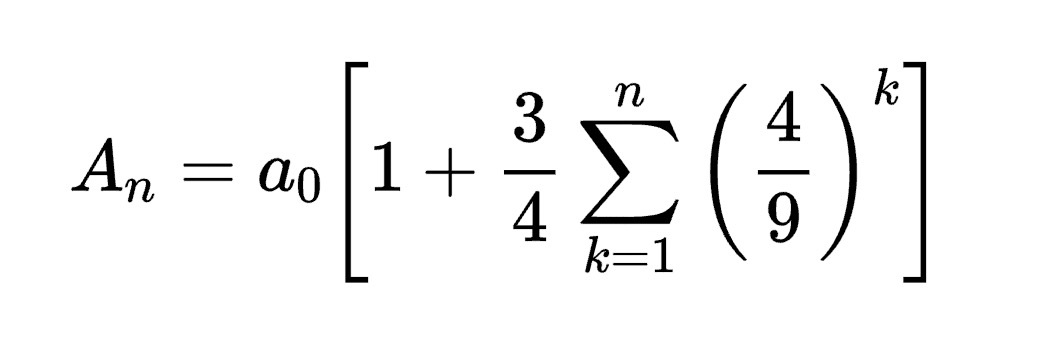

In [ ]:
input_image

In [ ]:
%%time

try:
    response = predictor.predict(data)
except Exception as ex:
    import traceback
    traceback.print_exc()

CPU times: user 0 ns, sys: 3.76 ms, total: 3.76 ms
Wall time: 2.16 s


In [ ]:
print(response)

\begin{align*}
& A_n = a_0 \begin{bmatrix} 1 & + \frac{3}{4} \sum_{k=1}^n \sum_{k=1}^k (4 \frac{k}{9}) \\
& \end{bmatrix} \\
\end{align*}


### Text-to-Image Generation

In [ ]:
%%time
try:
    text = "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair"
    response = predictor.predict(text,
        initial_args={
            "ContentType": "application/x-text",
            "Accept": "application/json"
        })
except Exception as ex:
    import traceback
    traceback.print_exc()

CPU times: user 3.88 ms, sys: 8.27 ms, total: 12.2 ms
Wall time: 20.1 s


In [ ]:
import base64
from io import BytesIO
from PIL import Image


def base64_to_pil_image(base64_string):
  image_bytes = base64.b64decode(base64_string)
  image_buffer = BytesIO(image_bytes)
  pil_image = Image.open(image_buffer).convert('RGB')
  return pil_image

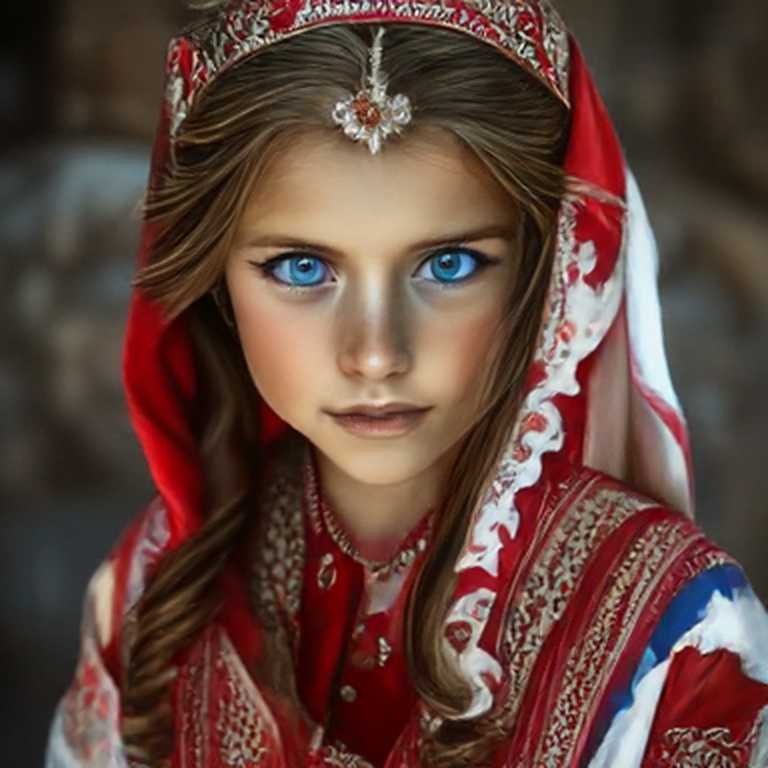

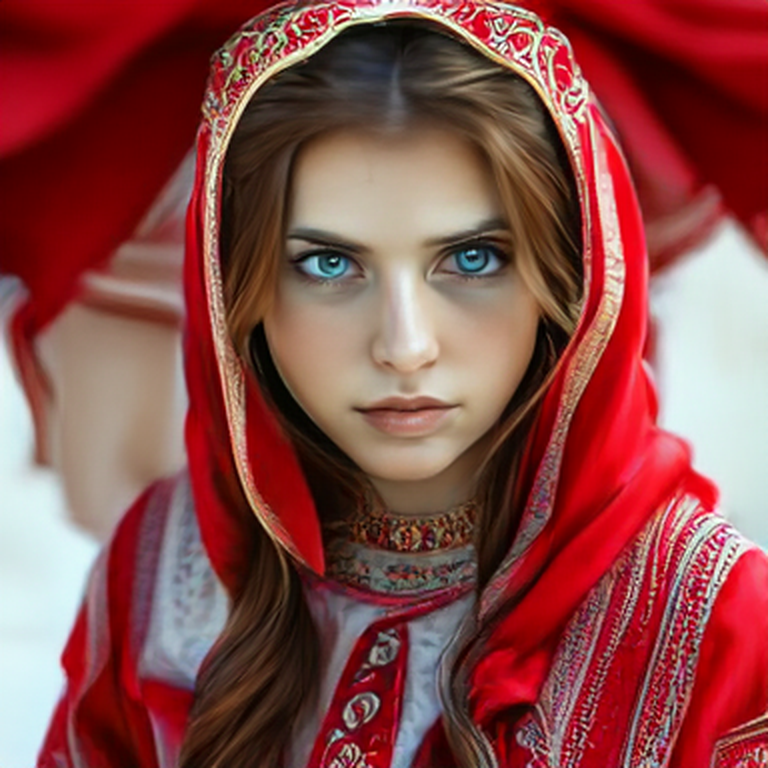

In [ ]:
pil_image_list = [base64_to_pil_image(e) for e in response]
for img in pil_image_list:
    img.show()

In [ ]:
%%time
try:
    text = "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair"
    data = {
        "prompt": text,

        # the followings are optional
        "task": "text-to-image",
        "generate_kwargs": {
            "guidance": 5,
            "temperature": 1.0,
            "parallel_size": 2,
            "image_token_num_per_image": 576
        }
    }
    response = predictor.predict(data)
except Exception as ex:
    import traceback
    traceback.print_exc()

CPU times: user 17.7 ms, sys: 3.25 ms, total: 20.9 ms
Wall time: 20 s


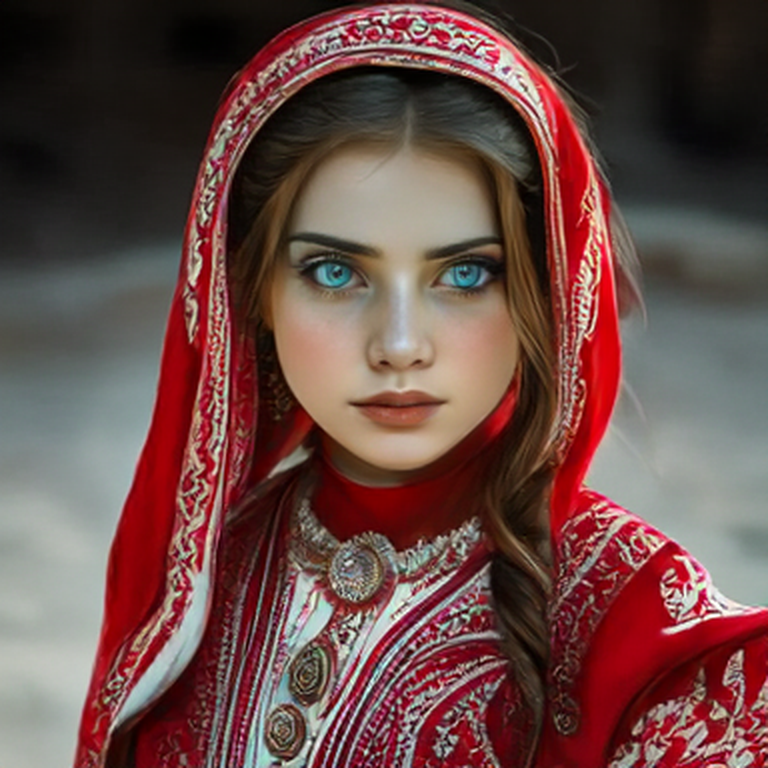

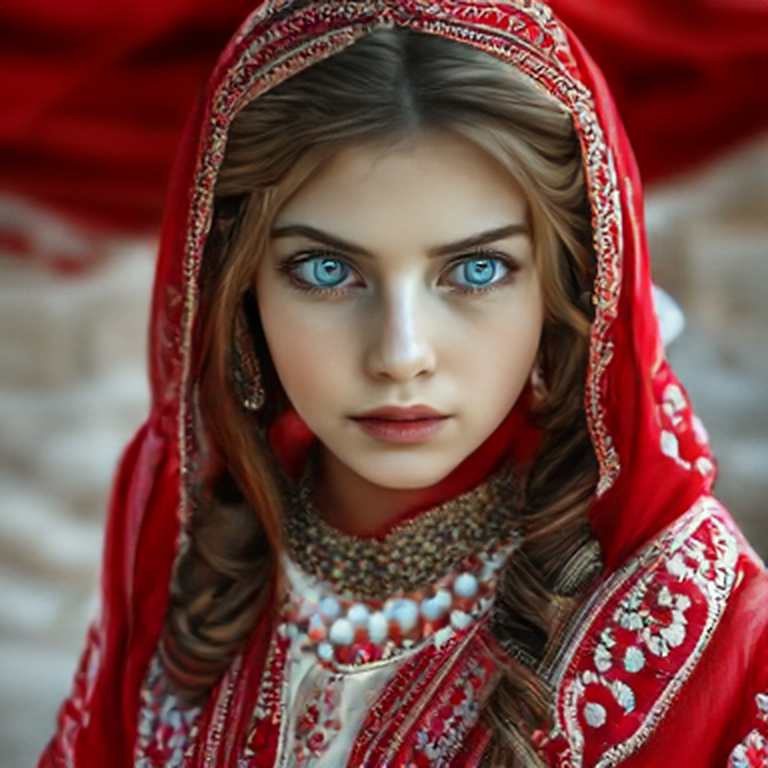

In [ ]:
pil_image_list = [base64_to_pil_image(e) for e in response]
for img in pil_image_list:
    img.show()

## Clean Up

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

## References

- [deepseek-ai/Janus-Pro-1B](https://huggingface.co/deepseek-ai/Janus-Pro-1B)
- [deepseek-ai/Janus-Pro-7B](https://huggingface.co/deepseek-ai/Janus-Pro-7B)
- [DeepSeek in HuggingFace](https://huggingface.co/deepseek-ai)
- [(GitHub) Janus](https://github.com/deepseek-ai/Janus/) - Unified Multimodal Understanding and Generation Models